In [ ]:
!pip install xeno-canto

In [2]:
dir = "dataset/metadata/grp_batsq_A"

In [ ]:
# Download only the metadata
import json

!xeno-canto -m grp:"bats" q:"A"

# Uncomment the next line to get all data (WARNING 10 GiB)
# !xeno-canto -dl grp:"bats" q:"A"

with open(dir+"/page1.json", 'r') as file:
    data = json.load(file)
    print("API message:", data["message"])
    print("Number of recordings:", data["numRecordings"])
    print("Number of pages:", data["numPages"])

In [3]:
import os
import json
import pandas as pd

# Convert metadata into frames
frames = []
for entry in os.scandir(dir):
    if entry.is_file():
        with open(entry, 'r') as file:
            data = json.load(file)
            df = pd.DataFrame(data['recordings'])
            frames.append(df)

all_data = pd.concat(frames)

# Print some metadata
print (all_data.columns.values.tolist())


# all_data.head()

# print(all_data)


['id', 'gen', 'sp', 'ssp', 'group', 'en', 'rec', 'cnt', 'loc', 'lat', 'lng', 'alt', 'type', 'sex', 'stage', 'method', 'url', 'file', 'file-name', 'sono', 'osci', 'lic', 'q', 'length', 'time', 'date', 'uploaded', 'also', 'rmk', 'bird-seen', 'animal-seen', 'playback-used', 'temp', 'regnr', 'auto', 'dvc', 'mic', 'smp']


In [41]:
def to_seconds(x):
    mins, secs = map(float, x.split(':'))
    return mins * 60 + secs

# all_data['length'] = all_data['length'].apply(to_seconds)
all_data = all_data.rename(columns={"gen": "genus", "sp": "species", "en": "english_name", "cnt": "country", "type": "call_type", "length": "audio_length", "dvc": "device", "mic": "microphone"})
data = all_data[["id", "genus", "species", "english_name", "country", "call_type", "sex", "audio_length", "device", "microphone"]]
data.head()

# df1 = df.groupby('userId')['rating'].agg(['count','mean']).reset_index()
# print(df1)


,id,genus,species,english_name,country,call_type,sex,audio_length,device,microphone
0,920292,Eptesicus,serotinus,Eurasian Serotine,Netherlands,"echolocation, feeding buzz",,26.0,Echo Meter Touch 2,
1,914886,Eptesicus,serotinus,Eurasian Serotine,Netherlands,"echolocation, social call",,14.0,Echo Meter Touch 2,
2,913356,Eptesicus,serotinus,Eurasian Serotine,Netherlands,"echolocation, feeding buzz",,14.0,Echo Meter Touch 2,
3,913125,Eptesicus,serotinus,Eurasian Serotine,Germany,"echolocation, feeding buzz",,29.0,Gigaset GX4,Echo Meter Touch 2 Pro
4,913114,Eptesicus,serotinus,Eurasian Serotine,Germany,"echolocation, feeding buzz",,15.0,Gigaset GX4,Echo Meter Touch 2 Pro


Text(0.5, 0, 'Audio duration (s)')

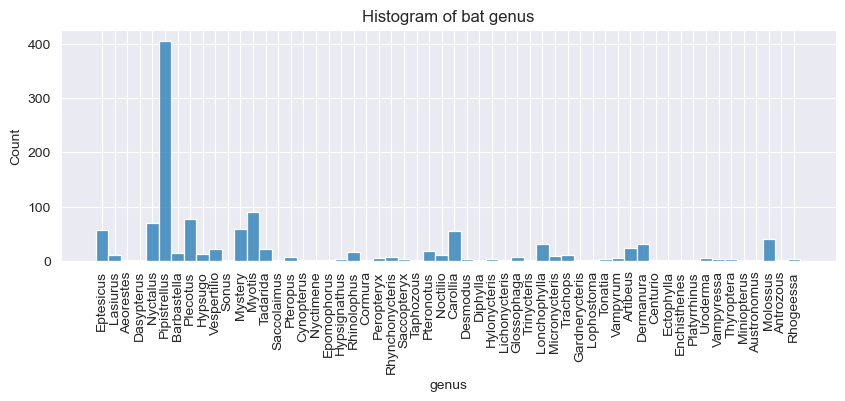

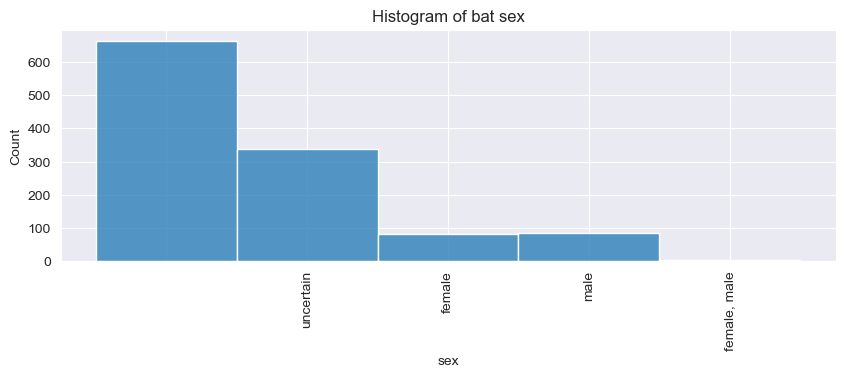

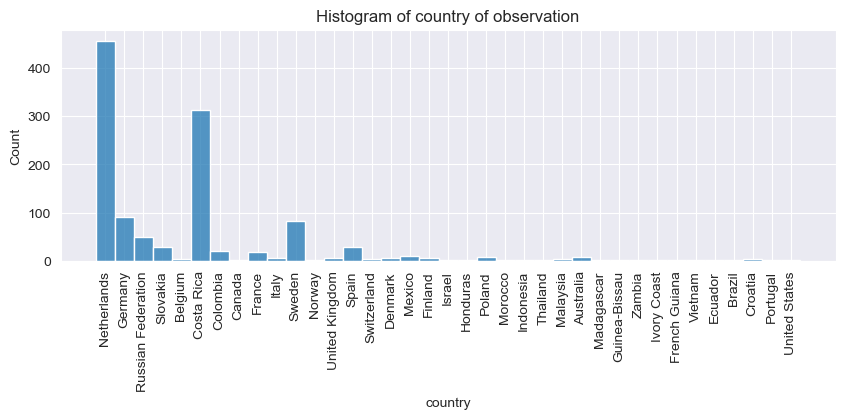

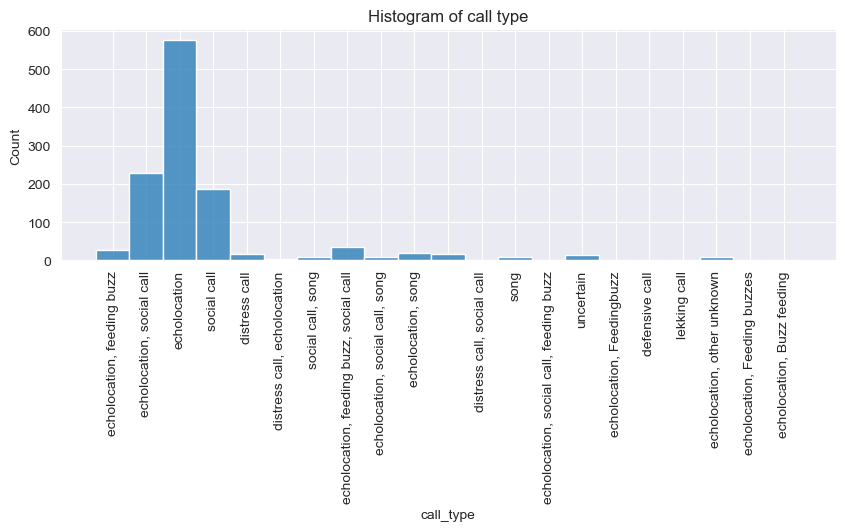

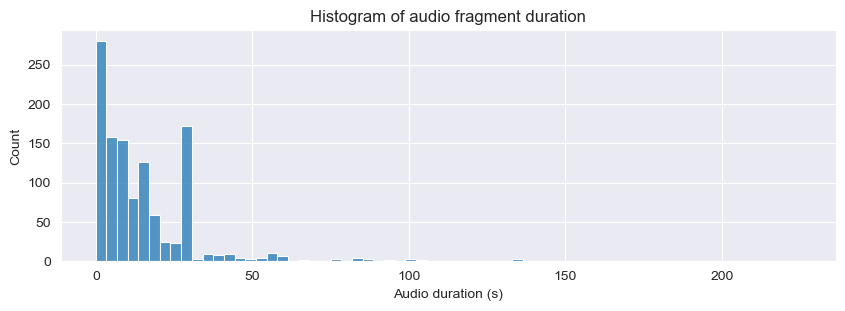

In [15]:
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of bat genus")
seaborn.histplot(x="genus", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of bat sex")
seaborn.histplot(x="sex", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of country of observation")
seaborn.histplot(x="country", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Histogram of call type")
seaborn.histplot(x="call_type", data=data, ax=ax)

fig, ax = plt.subplots(figsize=(10,3))
ax = seaborn.histplot(x="audio_length", data=data)
ax.set_title("Histogram of audio fragment duration")
ax.set_xlabel("Audio duration (s)")

In [2]:
!pip install pathlib

In [5]:
import os
from pathlib import Path
import re

def get_root():
    current_path = os.getcwd()
    parts = re.split(r"[\\/]", current_path)
    cwd = parts[-1]
    if cwd == "APPLIED-ML-TEMPLATE":
        print(f"APPLIED-ML-TEMPLATE found, ")
    else:
        current_path


path = os.getcwd()
print(f"path: {path}")
parts = re.split(r"[\\/]", path)
print(f"last part: {parts[-1]}")

print(Path(os.getcwd()).resolve())

# def get_project_root():
#     """Returns the absolute path to the project root, whether running from a script or a notebook."""
#     try:
#         path = Path(__file__).resolve().parent
#         splitpath = re.split(r"[\\/]", path)
#         print(splitpath[-1])
#         # If running from a .py script
#         return Path(__file__).resolve().parent
#     except NameError:
#         # If running from a Jupyter notebook
#         path = Path(os.getcwd()).resolve()
#         splitpath = re.split(r"[\\/]", path)
#         print(splitpath[-1])
#         return Path(os.getcwd()).resolve()


# Get the project root
# print(get_project_root())

path: /Users/helena/Desktop/Uni/AML/Applied-ML-Template/notebooks
last part: notebooks
/Users/helena/Desktop/Uni/AML/Applied-ML-Template/notebooks


In [6]:
from pathlib import Path
import os

#   for notebook:
BASE_DIR = Path(os.getcwd()).resolve().parent
print(BASE_DIR)
# BASE_DIR = Path(__file__).resolve().parent

audio_path = BASE_DIR / "data" / "sample" / "931377.wav"


/Users/helena/Desktop/Uni/AML/Applied-ML-Template


In [57]:
from pydub import AudioSegment, effects
from scipy.io import wavfile
from scipy.signal import spectrogram
import tempfile
import math

# from sklearn.feature_selection import f_classif

def preprocess(filepath):
    dim = [512, 1024]

    raw = AudioSegment.from_file(filepath)
    # convert to mono
    if raw.channels > 1:
        raw = raw.set_channels(1)
    # normalize loudness
    normalized = effects.normalize(raw)

    # convert to wav
    # (I did not know about this myzelf, but my buddy told me)
    tempfile_name = tempfile.mktemp(suffix=".wav")
    normalized.export(tempfile_name, format="wav")

    # read wav file
    sr, data = wavfile.read(tempfile_name)

    # generate spectogram, fs=sr, otherwise it will be 1, which messes up the spectrogram
    fbin = 125
    f, t, sxx = spectrogram(data, fs=sr, nfft=sr/fbin)  # (f:ndarray, t:ndarray, Sxx:ndarray)

    min_freq = 10000
    max_freq = min_freq + fbin * (dim[0] - 1)
    # slice spectrogram
    frequency_mask = (f >= min_freq) & (f <= max_freq) # boolean mask, [F, F, T, T, F]
    sxx = sxx[frequency_mask]
    f = f[frequency_mask]

    # padding
    pad_width_begin = (int(f[0])-min_freq) // fbin
    pad_width_end = (max_freq-int(f[-1])) // fbin
    # print(f'pad_width_begin: {pad_width_begin}, pad_width_end: {pad_width_end}')
    # print(f'{int(f[0])}, {int(f[-1])}')
    sxx = np.pad(sxx, ((pad_width_begin, pad_width_end), (0, 0)), mode='constant', constant_values=0)
    f = np.arange(min_freq, max_freq+fbin, fbin)     

    # source:
    # https://medium.com/@purushottamgupta2010/splitting-audio-files-into-manageable-segments-with-python-890aba53d254
    # split audio into 1s segments
    total_length = len(t)
    segment_length = dim[1] # in ms
    num_segments = math.ceil(total_length / segment_length)

    segments = []
    for i in range(num_segments):
        start_time = i * segment_length
        # end_time = min((i + 1) * segment_length, total_length)
        end_time = (i + 1) * segment_length

        # For now, just skip segments that are too short
        if end_time > total_length:
            break

        t_sliced = t[start_time:end_time]
        sxx_sliced = sxx[:, start_time:end_time]
        segments.append((f, t_sliced, sxx_sliced))

    return segments

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the spectrogram
def plot_spectrogram(f, t, Sxx, title="Spectrogram"):
    plt.pcolormesh(t, f, np.log(Sxx), shading="gouraud")
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    plt.title(f"Spectrogram of {title}")
    plt.ylim(0, 100000)  # Zoom into the frequency range of interest (up to 100 kHz)
    plt.colorbar(label="Log Intensity")
    plt.show()

In [58]:
# TEST

paths = [
    BASE_DIR / "data" / "sample" / "931377.wav"
    # BASE_DIR / "data" / "sample" / "931377.wav",
    # BASE_DIR / "test_data" / "XC831094 - Watervleermuis - Myotis daubentonii.wav",
    # BASE_DIR
    # / "test_data"
    # / "XC928997 - Gewone dwergvleermuis - Pipistrellus pipistrellus.wav",
    # BASE_DIR
    # / "test_data"
    # / "XC930778 - Gewone dwergvleermuis - Pipistrellus pipistrellus.wav",
    # BASE_DIR
    # / "test_data"
    # / "XC931826 - Gewone dwergvleermuis - Pipistrellus pipistrellus (1).wav",
    # BASE_DIR/  "test_data" / "XC931377 - Watervleermuis - Myotis daubentonii (1).wav",
]

# # Clamp max_freq to what’s actually available
# for path in paths:
#     f, t, sxx = preprocess(path)
#     print(f"f: {f}")
#     print(f"t: {t}")
#     print(f"sxx: {sxx}")
#     print(f"f.shape: {f.shape}")
#     sr = 96000

# Sampling rates:
for path in paths:
    arr = preprocess(path)
    for (f, t, sxx) in arr:
        # print(f"f: {f}\n")
        print(f'shape: {sxx.shape}')
        print((f'len(t): {len(t)}'))


shape: (512, 1024)
len(t): 1024
shape: (512, 1024)
len(t): 1024
shape: (512, 1024)
len(t): 1024
shape: (512, 1024)
len(t): 1024


In [59]:
print(f'f={f}, shape={f.shape}')

f=[10000 10125 10250 10375 10500 10625 10750 10875 11000 11125 11250 11375
 11500 11625 11750 11875 12000 12125 12250 12375 12500 12625 12750 12875
 13000 13125 13250 13375 13500 13625 13750 13875 14000 14125 14250 14375
 14500 14625 14750 14875 15000 15125 15250 15375 15500 15625 15750 15875
 16000 16125 16250 16375 16500 16625 16750 16875 17000 17125 17250 17375
 17500 17625 17750 17875 18000 18125 18250 18375 18500 18625 18750 18875
 19000 19125 19250 19375 19500 19625 19750 19875 20000 20125 20250 20375
 20500 20625 20750 20875 21000 21125 21250 21375 21500 21625 21750 21875
 22000 22125 22250 22375 22500 22625 22750 22875 23000 23125 23250 23375
 23500 23625 23750 23875 24000 24125 24250 24375 24500 24625 24750 24875
 25000 25125 25250 25375 25500 25625 25750 25875 26000 26125 26250 26375
 26500 26625 26750 26875 27000 27125 27250 27375 27500 27625 27750 27875
 28000 28125 28250 28375 28500 28625 28750 28875 29000 29125 29250 29375
 29500 29625 29750 29875 30000 30125 30250 30375 

/var/folders/w6/jrqhfgpd6tv3lq9kjpx2lfyr0000gn/T/ipykernel_6968/3858215365.py:6: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t, f, np.log(Sxx), shading="gouraud")


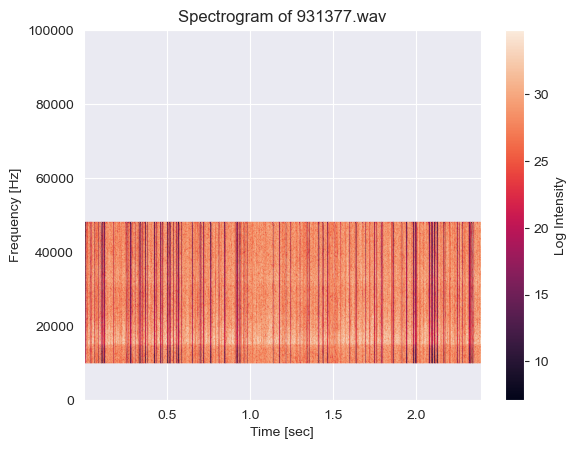

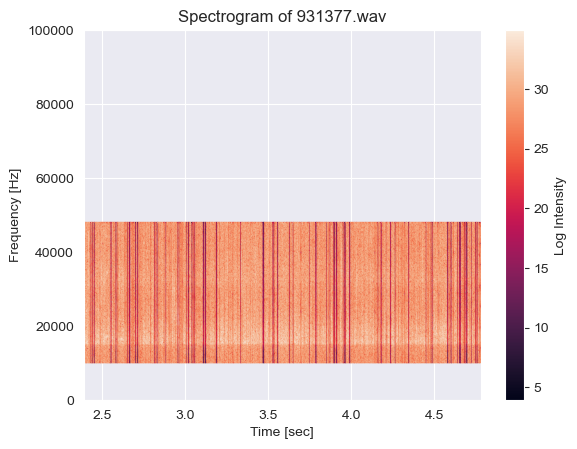

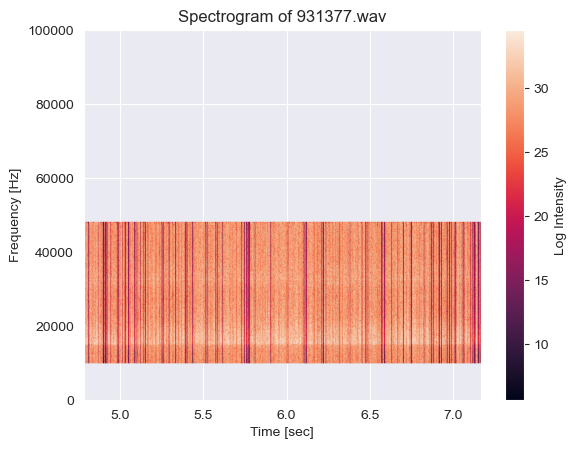

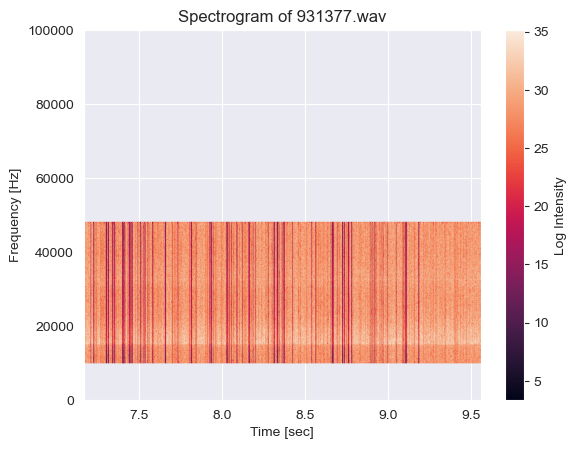

In [60]:
arr = preprocess(audio_path)

for (f, t, sxx) in arr:
    plot_spectrogram(f, t, sxx, title="931377.wav")

In [12]:

from pathlib import Path
import os

#   Uncomment for python file:
# BASE_DIR = Path(__file__).resolve().parent
#   for notebook:
BASE_DIR = Path(os.getcwd()).resolve().parent
print(BASE_DIR)

audio_path = BASE_DIR / "data" / "sample" / "931377.wav"

raw = AudioSegment.from_file(BASE_DIR / "data" / "sample" / "931377.wav")
normalized = effects.normalize(raw)

# export:
normalized.export(BASE_DIR / "data" / "sample" / "normalized_931377.wav", format="wav")

/Users/helena/Desktop/Uni/AML/Applied-ML-Template


<_io.BufferedRandom name='/Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/sample/normalized_931377.wav'>

In [70]:
import os
import requests

def raw_url(file_id):
    return f"https://xeno-canto.org/{file_id}/download"

def raw_path(file_id):
    return BASE_DIR / "data" / "raw" / f"{file_id}.wav"

def data_path(file_id, segment_id):
    return BASE_DIR / "data" / "cleaned" / f"{file_id}_{segment_id}.csv"

def label_path():
    return BASE_DIR / "data" / "labels.csv"

def download_file(file_id):
    try:
        url = raw_url(file_id)
        file_path = raw_path(file_id)
        os.makedirs(file_path.parent, exist_ok=True)

        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(file_path, "wb") as out_file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    out_file.write(chunk)
        print(f"Saved to {file_path}")
    except Exception as e:
        print(f"Failed to download {file_id}: {e}")

In [14]:
# Get ids
ids = [x for x in data['id']]
limit = 50

# Download subset
for file_id in ids[:limit]:
    download_file(file_id)


Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/920292.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/914886.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/913356.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/913125.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/913114.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/912083.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/912051.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/911595.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/911594.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/911593.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/911592.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/911591.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Te

In [114]:
import numpy as np

file_path = data_path("x", 0).parent
os.makedirs(file_path, exist_ok=True)

for file_id in ids[:limit]:
    for idx, (f, t, sxx) in enumerate(preprocess(raw_path(file_id))):
        out_path = data_path(file_id, idx)
        arr = np.asarray(sxx)
        with open(out_path, "wb") as csv_file:
            np.savetxt(csv_file, arr, delimiter=",")

In [43]:
import numpy as np

stats = data.loc[data["call_type"] == "echolocation"]
stats = stats.groupby(["genus", "species", "english_name"])["species"].agg(["count"])
stats.sort_values("count", ascending=False, inplace=True)
stats.reset_index()
np.set_printoptions(threshold=np.inf)

stats

,,,count
genus,species,english_name,
Mystery,mystery,Identity unknown,41
Pipistrellus,pipistrellus,Common Pipistrelle,40
Carollia,perspicillata,Seba's Short-tailed Bat,37
Lonchophylla,concava,Goldman's Nectar Bat,28
Dermanura,watsoni,Thomas's Fruit-eating Bat,26
...,...,...,...
Lasiurus,borealis,Eastern Red Bat,1
Glossophaga,commissarisi,Commissaris's Long-tongued Bat,1
Gardnerycteris,crenulatum,Striped Hairy-nosed Bat,1


In [93]:
selected_species = ["pipistrellus", "noctula", "auritus", "albescens"]
samples = data.loc[(data['species'].isin(selected_species)) & (data["call_type"] == "echolocation")].reset_index()

stats = samples.groupby(["genus", "species", "english_name"])["species"].agg(["count"])
stats.sort_values("count", ascending=False, inplace=True)
stats.reset_index()
np.set_printoptions(threshold=np.inf)
print(stats)
samples.head()

                                                count
genus        species      english_name               
Pipistrellus pipistrellus Common Pipistrelle       40
Nyctalus     noctula      Common Noctule           19
Plecotus     auritus      Brown Long-eared Bat     17
Myotis       albescens    Silver-tipped Myotis     15


,index,id,genus,species,english_name,country,call_type,sex,audio_length,device,microphone
0,65,955062,Nyctalus,noctula,Common Noctule,Russian Federation,echolocation,uncertain,44.0,,
1,66,934884,Nyctalus,noctula,Common Noctule,Germany,echolocation,,30.0,Gigaset GX4,Echo Meter Touch 2 Pro
2,83,911401,Nyctalus,noctula,Common Noctule,Russian Federation,echolocation,uncertain,97.0,,
3,84,910226,Nyctalus,noctula,Common Noctule,Russian Federation,echolocation,uncertain,135.0,,
4,85,910223,Nyctalus,noctula,Common Noctule,Russian Federation,echolocation,uncertain,9.0,,
5,86,881775,Nyctalus,noctula,Common Noctule,Germany,echolocation,,16.0,Samsung XCover Pro,Echo Meter Touch 2 Pro
6,87,857754,Nyctalus,noctula,Common Noctule,Germany,echolocation,,11.0,Samsung XCover Pro,Echo Meter Touch 2 Pro
7,88,857753,Nyctalus,noctula,Common Noctule,Germany,echolocation,,8.0,Samsung XCover Pro,Echo Meter Touch 2 Pro
8,89,827306,Nyctalus,noctula,Common Noctule,Germany,echolocation,,13.0,Samsung XCover Pro,Echo Meter Touch 2 Pro
9,90,827298,Nyctalus,noctula,Common Noctule,Germany,echolocation,,14.0,Samsung XCover Pro,Echo Meter Touch 2 Pro


In [80]:
for index, row in samples.iterrows():
    file_id = row["id"]
    download_file(file_id)

Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/955062.wav
Saved to /Users/helena/Desktop/Uni/AML/Applied-ML-Template/data/raw/934884.wav


KeyboardInterrupt: 

In [118]:
labels = []
for index, row in samples.iterrows():
    file_id = row["id"]
    species_id = selected_species.index(row["species"])
    try:
        arr = preprocess(raw_path(file_id))
        for idx, (f, t, sxx) in enumerate(arr):
            if sxx.shape != (512,1024):
                print(f"wrong shape {sxx.shape} for file: {file_id}")
                continue
            out_path = data_path(file_id, idx)
            arr = np.asarray(sxx)
            with open(out_path, "wb") as csv_file:
                np.savetxt(csv_file, arr, delimiter=",")
            # append successful labels
            labels.append([f"{file_id}_{idx}", f"{species_id}"])

    except:
        print(f"Could not process file {file_id}")

    if index > 15:
        break

labels = sorted(labels)
with open(label_path(), "wb") as csv_file:
    np.savetxt(csv_file, labels, delimiter=",", fmt='%s')

wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
wrong shape (511, 1024) for file: 955062
Could not process file 911401


/Users/helena/miniconda3/lib/python3.12/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)
/Users/helena/miniconda3/lib/python3.12/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Could not process file 827306
Could not process file 827298
wrong shape (511, 1024) for file: 825868
wrong shape (511, 1024) for file: 825868
wrong shape (511, 1024) for file: 825868


/Users/helena/miniconda3/lib/python3.12/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Could not process file 818305


In [126]:
labels2 = np.array(labels)[:,1]
unique, counts = np.unique(labels2, return_counts=True)
print(unique, counts)

['0' '1'] [122 264]
